In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # 필요한 모듈을 가져옵니다.

from matplotlib.backends.backend_agg import FigureCanvasAgg

In [2]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import EvalCallback
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback

In [3]:
from scheduler_env.customEnv_repeat import SchedulingEnv

In [4]:
env = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-hard.json", job_repeats_params = [(8, 1)] * 12)
check_env(env)

/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:30: UserWarning: It seems that your observation job_details is an image but its `dtype` is (int8) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:38: UserWarning: It seems that your observation space job_details is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:51: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  war

In [5]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

In [18]:
def print_result(info, detail_mode = False):
    current_repeats = info['current_repeats']
    print(f"Current Repeats\t\t\t:\t{current_repeats}")

    # 최종 점수 출력
    reward = info["reward"]
    print(f"Goal reached! Final score\t:\t{reward:.2f}")

    env = info["env"]

    cost_deadline = info["cost_deadline"]
    cost_hole = info["cost_hole"]
    cost_processing = info["cost_processing"]
    cost_makespan = info["cost_makespan"]
    sum_costs = cost_deadline + cost_hole + cost_processing + cost_makespan
    profit = env.total_durations / 100 * info["profit_ratio"]
    print(f"Total revenue\t\t\t:\t{profit:.2f} - {sum_costs:.2f} = {profit - sum_costs:.2f}")
    print(f"Sum of Costs\t\t\t:\t{cost_deadline + cost_hole + cost_processing + cost_makespan:.2f}")
    print(f"Cost Deadline\t\t\t:\t{cost_deadline:.2f}")
    print(f"Cost Hole\t\t\t:\t{cost_hole:.2f}")
    print(f"Cost Processing\t\t\t:\t{cost_processing:.2f}")
    print(f"Cost Makespan\t\t\t:\t{cost_makespan:.2f}")


    # 최종 완료 시간 출력    
    print(f"Finish Time / Target Time\t:\t{info['finish_time']} / {int(env.target_time)}")

    # jobs 생성
    jobs = []
    job_deadlines = info['job_deadline']
    job_tardiness = info['job_time_exceeded']
    index = 0

    if detail_mode:
        for repeat in current_repeats:
            for r in range(repeat):
                deadline = job_deadlines[index+r]
                tardiness = job_tardiness[index+r]
                print(f"Job {index + 1} - Repeat {r + 1}\t\t:\tTardiness/Deadline = {tardiness}/{deadline}")
            index += 1
        
    for job_id, repeat in enumerate(current_repeats, 1):
        job_info = {
            'job_id': job_id,
            'tardiness': job_tardiness[index:index+repeat],
            'deadline': job_deadlines[index:index+repeat]
        }
        jobs.append(job_info)
        index += repeat

    
    # Calculate Tardiness/Deadline ratios and assign colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
              '#aec7e8', '#ffbb78']  # Color palette for jobs
    
    ratios = []
    tardinesses = []
    x_labels = []
    bar_colors = []
    x_positions = []
    
    current_x = 0
    for job in jobs:
        # ratio = [t/d if d != 0 else 0 for t, d in zip(job['tardiness'], job['deadline'])]
        # ratios.extend(ratio)
        tardiness = [t for t in job['tardiness']]
        tardinesses.extend(tardiness)
        x_labels.extend([f'Job {job["job_id"]} - Repeat {i+1}' for i in range(len(tardiness))])
        bar_colors.extend([colors[job['job_id'] - 1]] * len(tardiness))
        x_positions.extend([current_x + i for i in range(len(tardiness))])
        current_x += len(tardiness) + 1  # Add space between different jobs

    # Calculate and print the average Tardiness/Deadline ratio
    avg_tardiness = np.mean(tardinesses)
    print(f"Average Tardiness:\t{avg_tardiness:.2f}")
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.8
    ax.bar(x_positions, tardinesses, width=bar_width, color=bar_colors)
    
    # Set x-ticks and x-tick labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=90, ha='center')
    ax.set_xlabel('Job - Repeat')
    ax.set_ylabel('Tardiness per Job repeat')
    ax.set_title('Tardiness per Job repeat')
    
    # Legend
    unique_jobs = list(set([f'Job {job["job_id"]}' for job in jobs]))
    legend_patches = [mpatches.Patch(color=colors[i], label=unique_jobs[i]) for i in range(len(unique_jobs))]
    legend_patches.sort(key=lambda x: int(x.get_label().split()[1]))
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [7]:
env_2_3_3 = SchedulingEnv(machine_config_path= "instances/Machines/v0-2.json", job_config_path = "instances/Jobs/v0-3x3-deadline.json", job_repeats_params = [(2, 1)] * 3)

In [8]:
env_8_12_3 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", job_repeats_params = [(3, 1)] * 12)

In [9]:
env_8_12_1_t = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", job_repeats_params = [(1, 1)] * 12, test_mode = True)

In [10]:
env_8_12_8_2 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-hard.json", job_repeats_params = [(8, 2)] * 12)

In [28]:
env_8_12_8_2_t = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-hard.json", job_repeats_params = [(8, 2)] * 12, test_mode = True)

In [15]:
env_8_12_8_t_p_20 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-hard.json", profit_per_time = 20, job_repeats_params = [(8, 2)] * 12, test_mode = True)

In [30]:
env = env_8_12_8_2_t

Current Repeats			:	[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Goal reached! Final score	:	-125.45
Total revenue			:	6400.00 - 14429.00 = -8029.00
Sum of Costs			:	14429.00
Cost Deadline			:	11780.00
Cost Hole			:	209.00
Cost Processing			:	1280.00
Cost Makespan			:	1160.00
Finish Time / Target Time	:	11600 / 8000
Average Tardiness:	2454.17


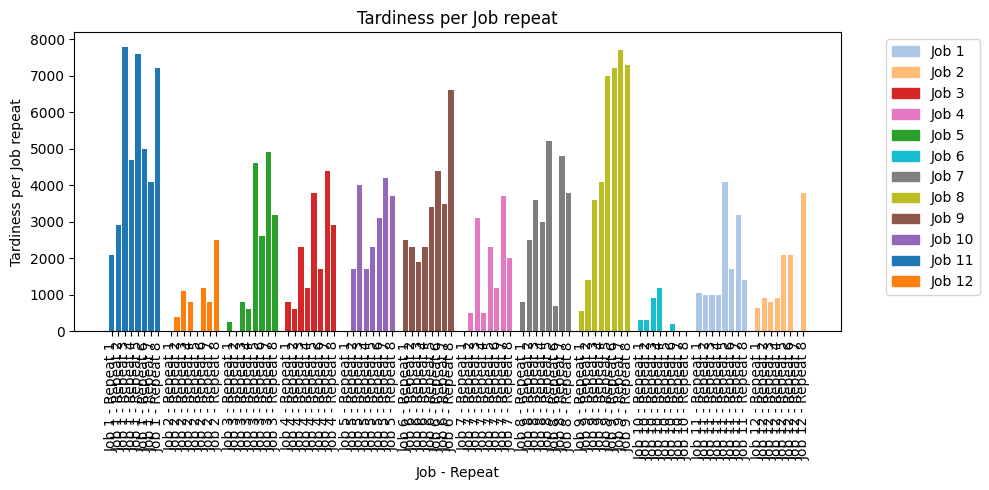

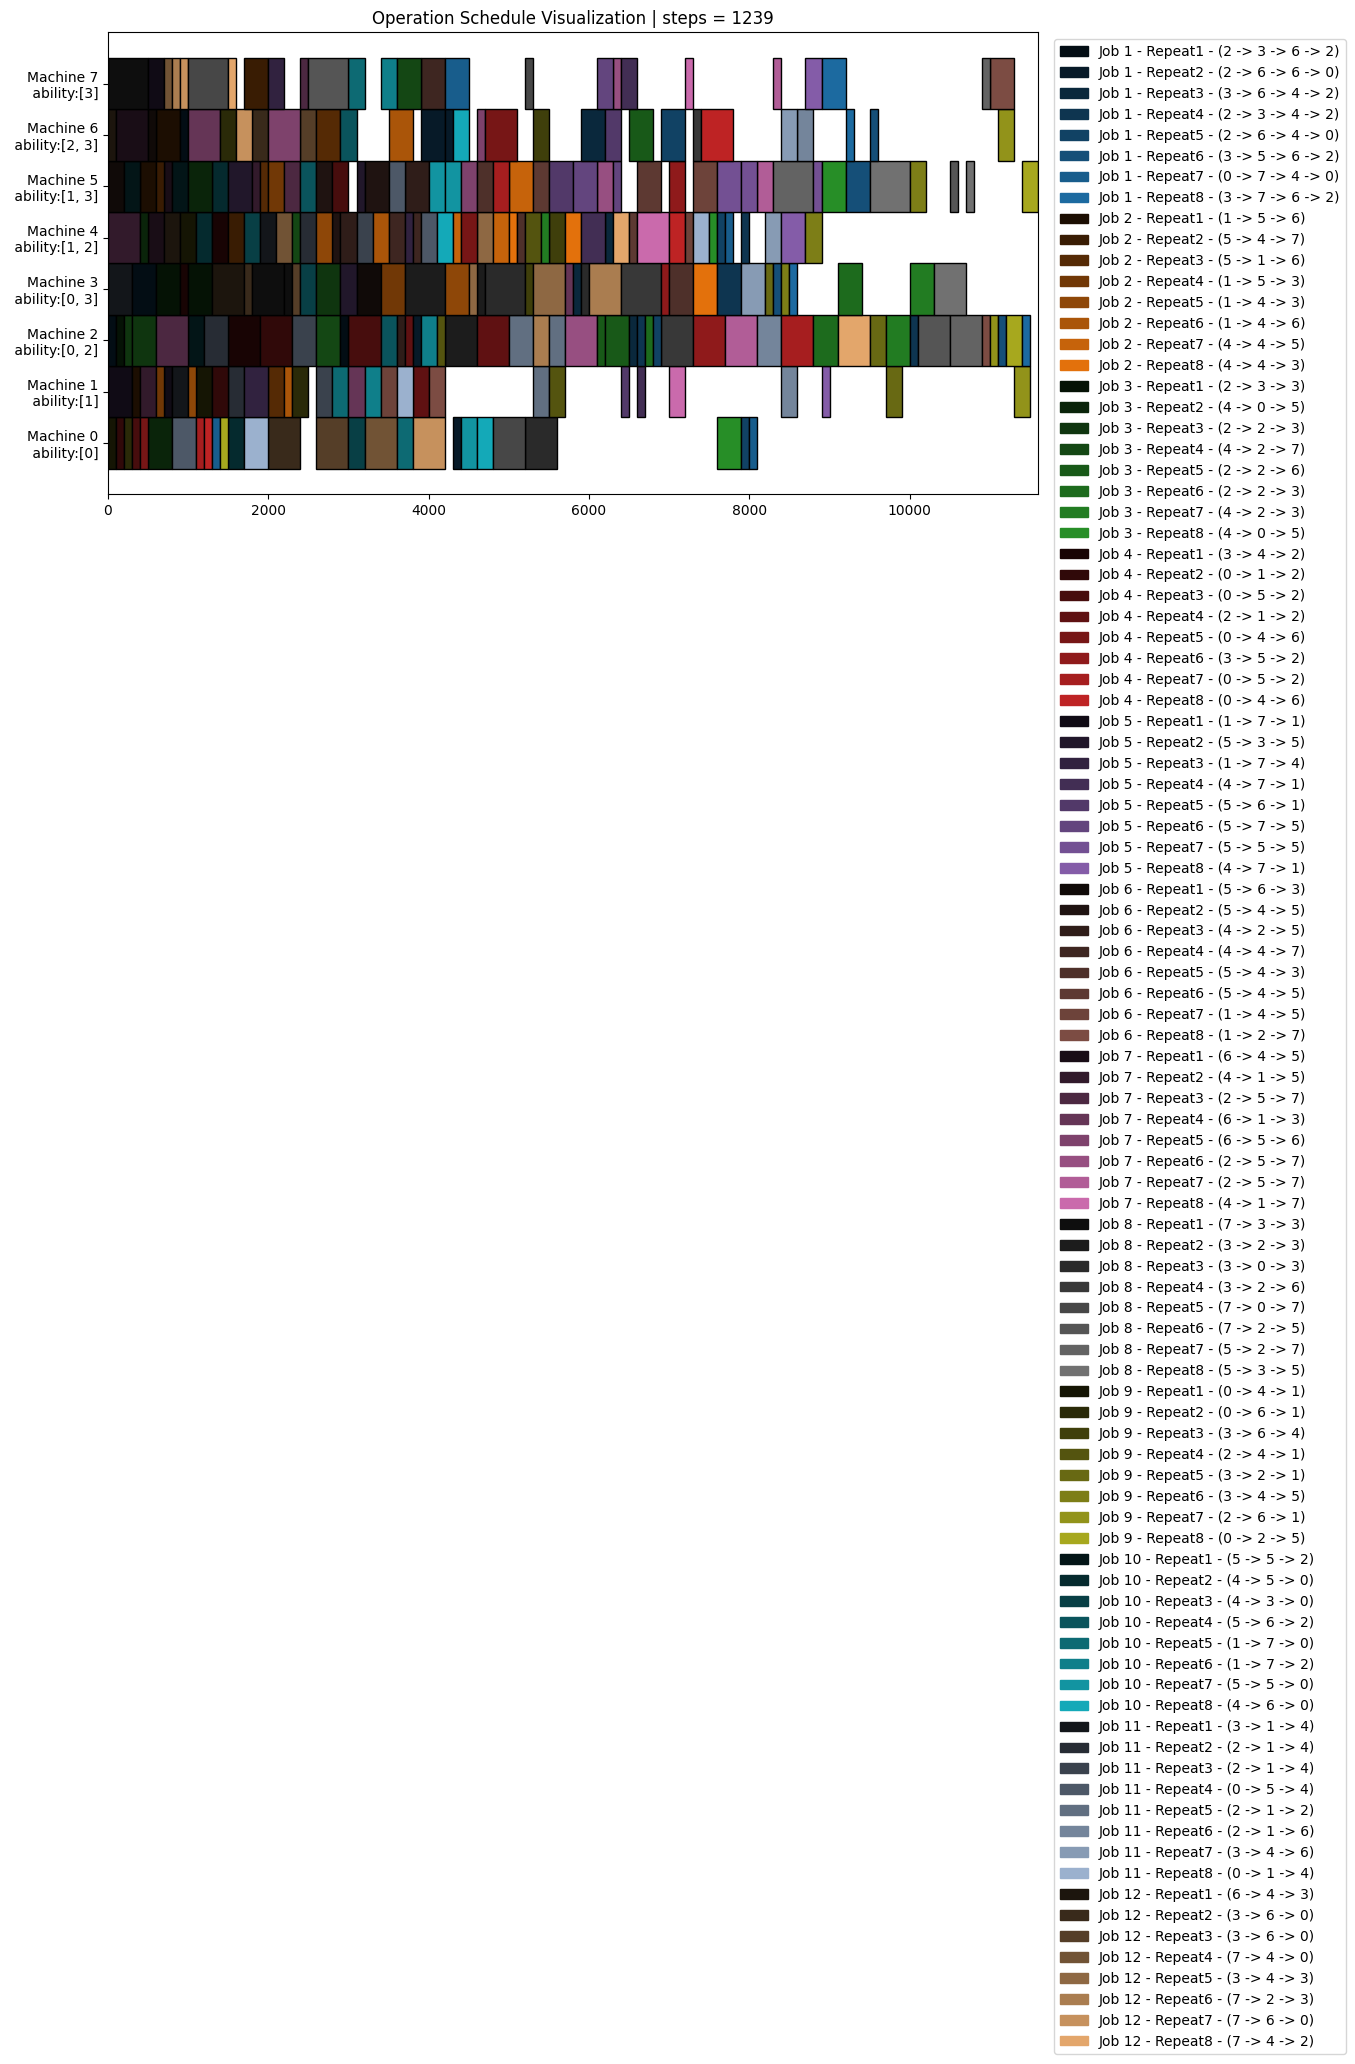

In [31]:
step = 0
obs, info = env.reset()

while True:
    step += 1
    action = env.action_space.sample()    
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    info["reward"] = reward
    info["env"] = env
    info["profit_ratio"] = env.profit_per_time
    
    if done:
        print_result(info)
        env.render()
        break

In [32]:
log_path = "./logs/tmp/cost_8_12_8_t"
# set up logger
new_logger = configure(log_path, ["stdout", "csv", "tensorboard"])

# Create the evaluation environment
eval_env = env
obs, info = eval_env.reset()

# Create the EvalCallback
eval_callback = EvalCallback(eval_env, best_model_save_path=log_path,
                             log_path=log_path, eval_freq=100000,
                             deterministic=True, render=False)

# Create the MaskableEvalCallback
maskable_eval_callback = MaskableEvalCallback(eval_env, best_model_save_path=log_path,
                             log_path=log_path, eval_freq=100000,
                             deterministic=True, render=False)

Logging to ./logs/tmp/cost_8_12_8_t


In [46]:
def linear_schedule(initial_value: float, final_value: float):
    def func(progress: float):
        return initial_value + progress * (final_value - initial_value)
    return func

In [53]:
### 하이퍼파라미터 목록
initial_lr = 0.001
final_lr = 0.0003

params = {
    "policy_kwargs" : dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])]),
    "gamma" : 1.0,
    "clip_range" : 0.25,
    "n_steps" : 1024,  
    "learning_rate" : 0.0007,
    }

In [ ]:
model = MaskablePPO('MultiInputPolicy', env, verbose=1, 
                    clip_range = params["clip_range"],
                    gamma = params["gamma"],
                    policy_kwargs = params["policy_kwargs"],
                    n_steps = params["n_steps"],
                    learning_rate = params["learning_rate"]
                   )
model.set_logger(new_logger)
model.learn(1000000, callback=maskable_eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 296        |
|    ep_rew_mean          | -151       |
| time/                   |            |
|    fps                  | 519        |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 1024       |
| train/                  |            |
|    approx_kl            | 0.37444052 |
|    clip_fraction        | 0.45       |
|    clip_range           | 0.298      |
|    entropy_loss         | -2.18      |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.000991   |
|    loss                 | 0.685      |
|    n_updates            | 120        |
|    policy_gradient_loss | -0.0473    |
|    value_loss           | 40.2       |
----------------------------------------
-----------------------------------------
| r

In [ ]:
model.save("MP_test_cost_8_12_8_t")

In [36]:
!tensorboard --logdir=./logs/tmp/cost_8_12_8_t

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.14.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [27]:
import os
import shutil

log_dir = "./logs/tmp/cost_8_12_8_t"

# 디렉토리 내 모든 파일과 서브 디렉토리 삭제
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
    print(f"{log_dir} 디렉토리와 그 안의 모든 내용이 삭제되었습니다.")
else:
    print(f"{log_dir} 디렉토리가 존재하지 않습니다.")

# 디렉토리 재생성 (필요한 경우)
os.makedirs(log_dir, exist_ok=True)
print(f"{log_dir} 디렉토리가 생성되었습니다.")

./logs/tmp/cost_8_12_8_t 디렉토리와 그 안의 모든 내용이 삭제되었습니다.
./logs/tmp/cost_8_12_8_t 디렉토리가 생성되었습니다.


In [ ]:
model = MaskablePPO.load("MP_test_cost_8_12_8")

In [20]:
def random_tardiness_simulation(repeats):
    j = []
    for r in repeats:
        j.append((r, 1))

    test_env = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat-hard.json", job_repeats_params = j, test_mode = True)
    step = 0
    obs, info = test_env.reset()
    while True:
        step += 1
        action = test_env.action_space.sample()    
        obs, reward, terminated, truncated, info = test_env.step(action)
        done = terminated or truncated
        info["reward"] = reward
        info["env"] = test_env
        info["profit_ratio"] = env.profit_per_time
        
        if done:
            print_result(info)
            test_env.render()
            break

Current Repeats			:	[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Goal reached! Final score	:	-111.62
Total revenue			:	6400.00 - 13543.50 = -7143.50
Sum of Costs			:	13543.50
Cost Deadline			:	10742.50
Cost Hole			:	101.00
Cost Processing			:	1280.00
Cost Makespan			:	1420.00
Finish Time / Target Time	:	14200 / 8000
Average Tardiness:	2238.02


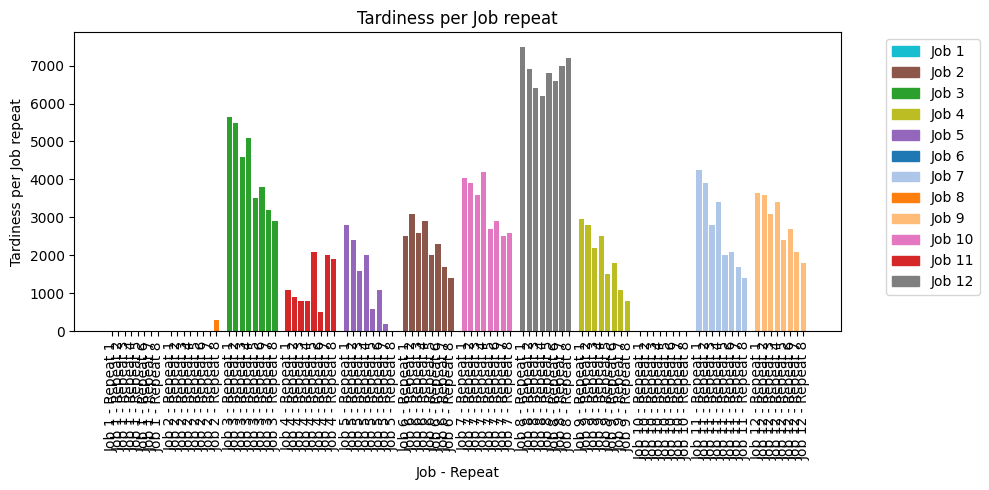

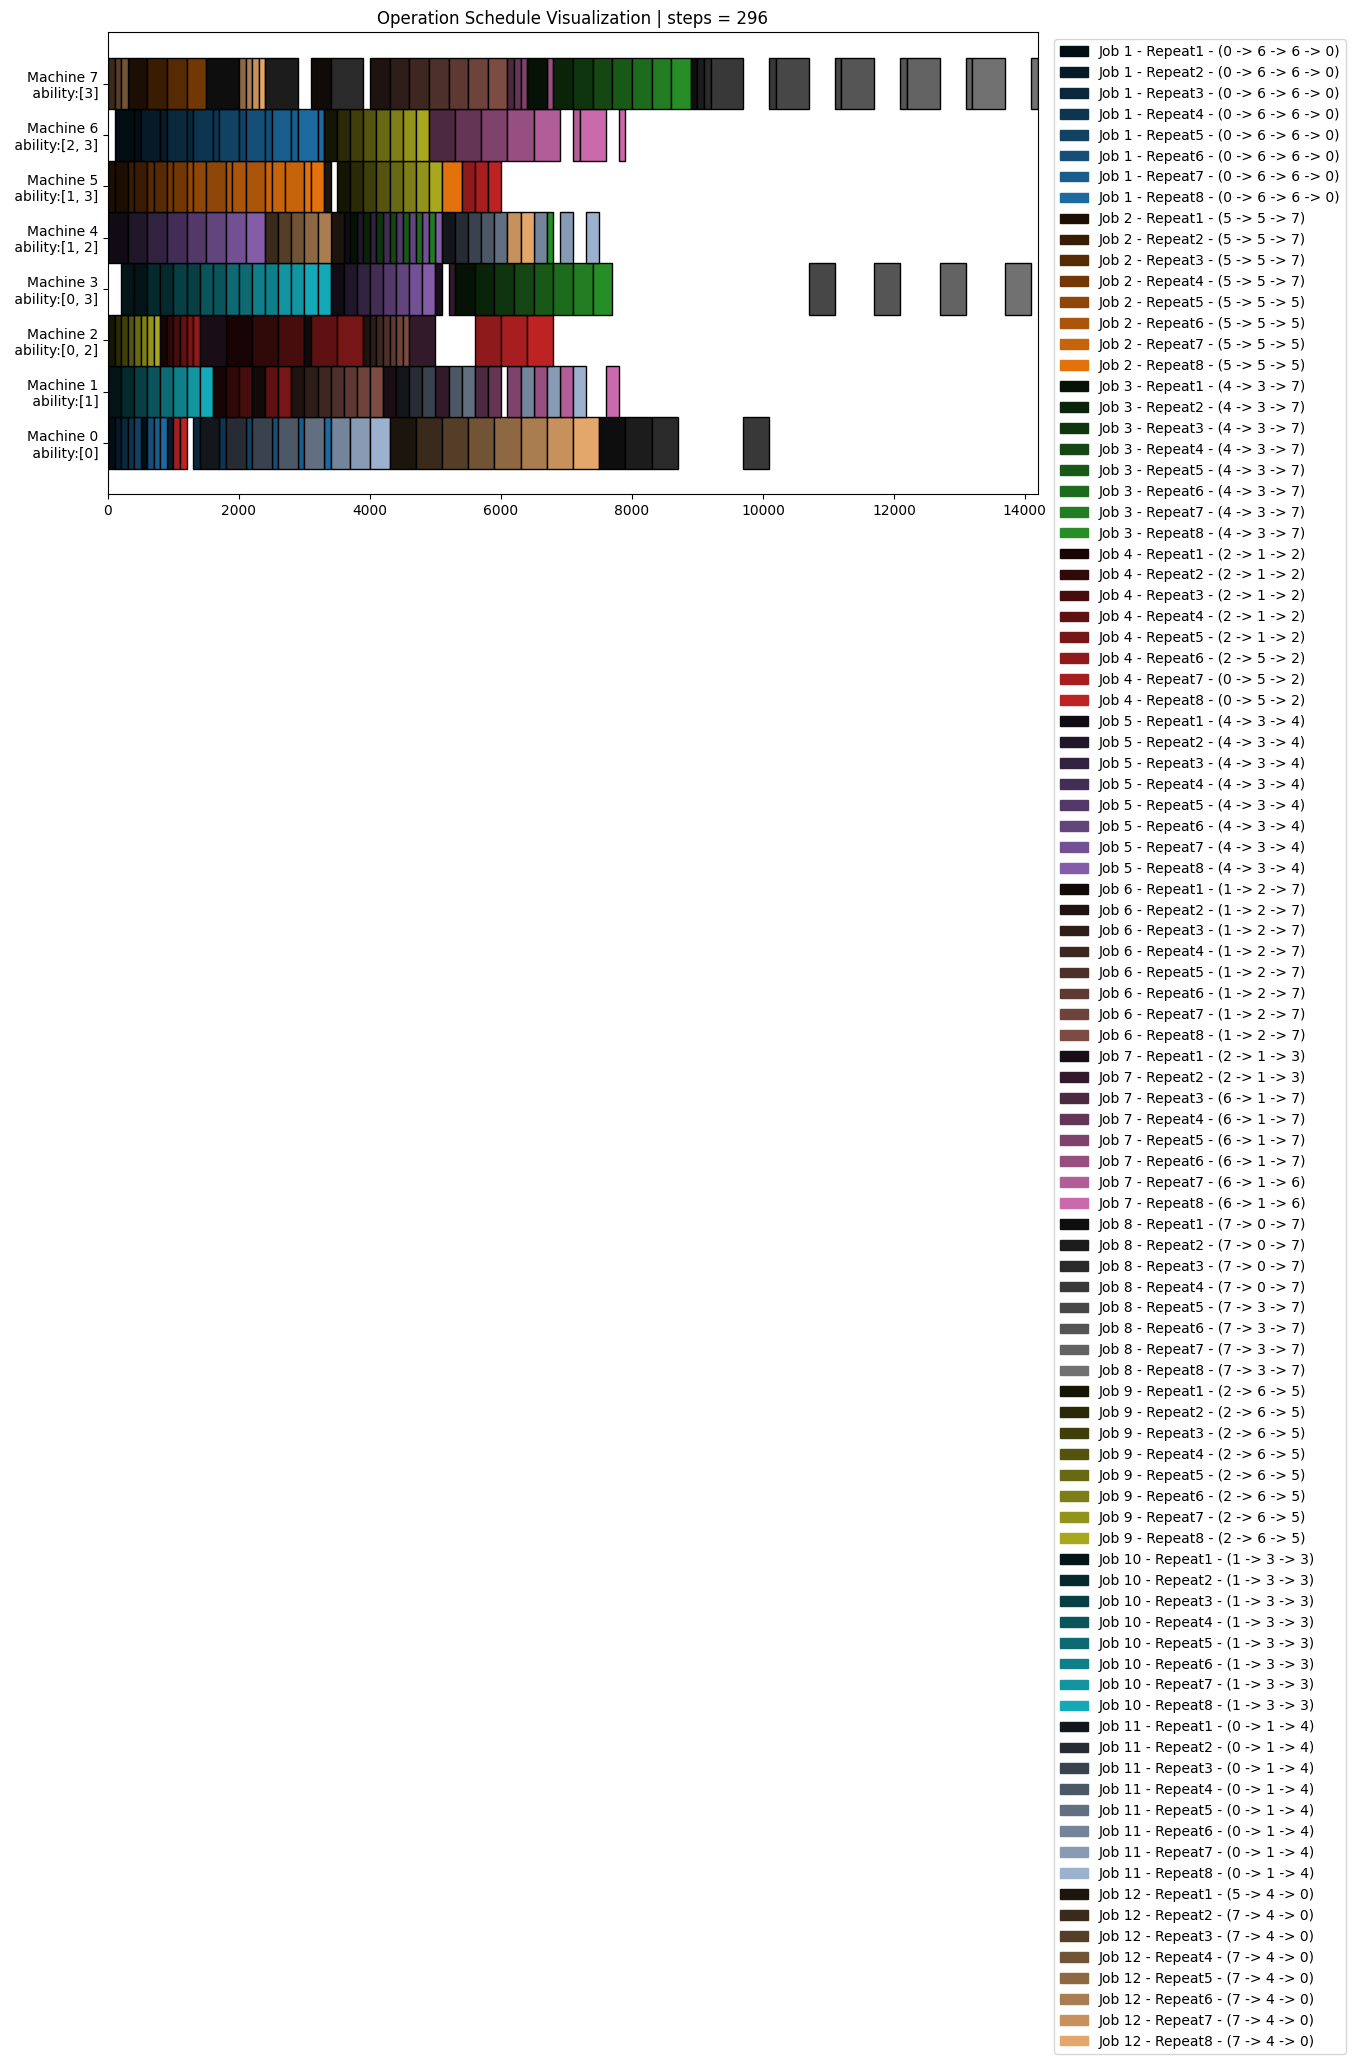




---------------------------Random Simmulation---------------------------
Current Repeats			:	[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Goal reached! Final score	:	-175.09
Total revenue			:	6400.00 - 17606.00 = -11206.00
Sum of Costs			:	17606.00
Cost Deadline			:	14910.00
Cost Hole			:	236.00
Cost Processing			:	1280.00
Cost Makespan			:	1180.00
Finish Time / Target Time	:	11800 / 8000
Average Tardiness:	3106.25


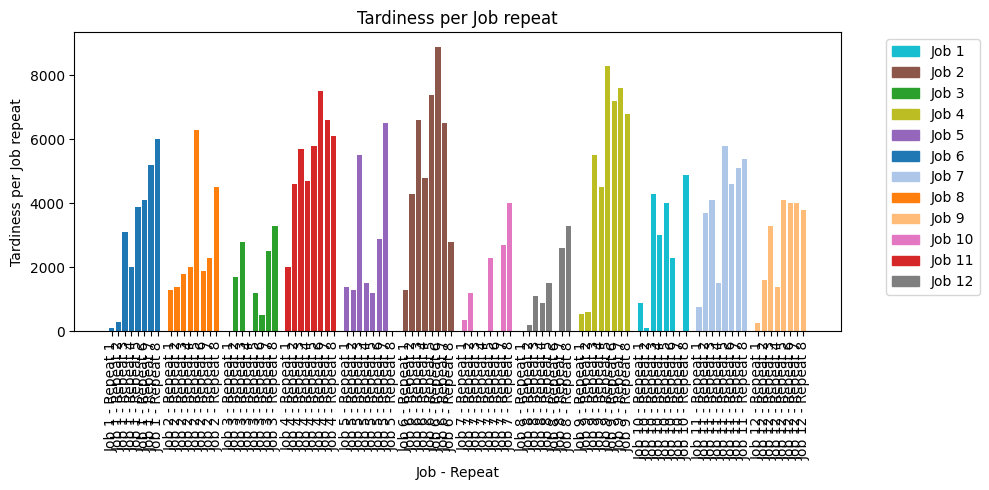

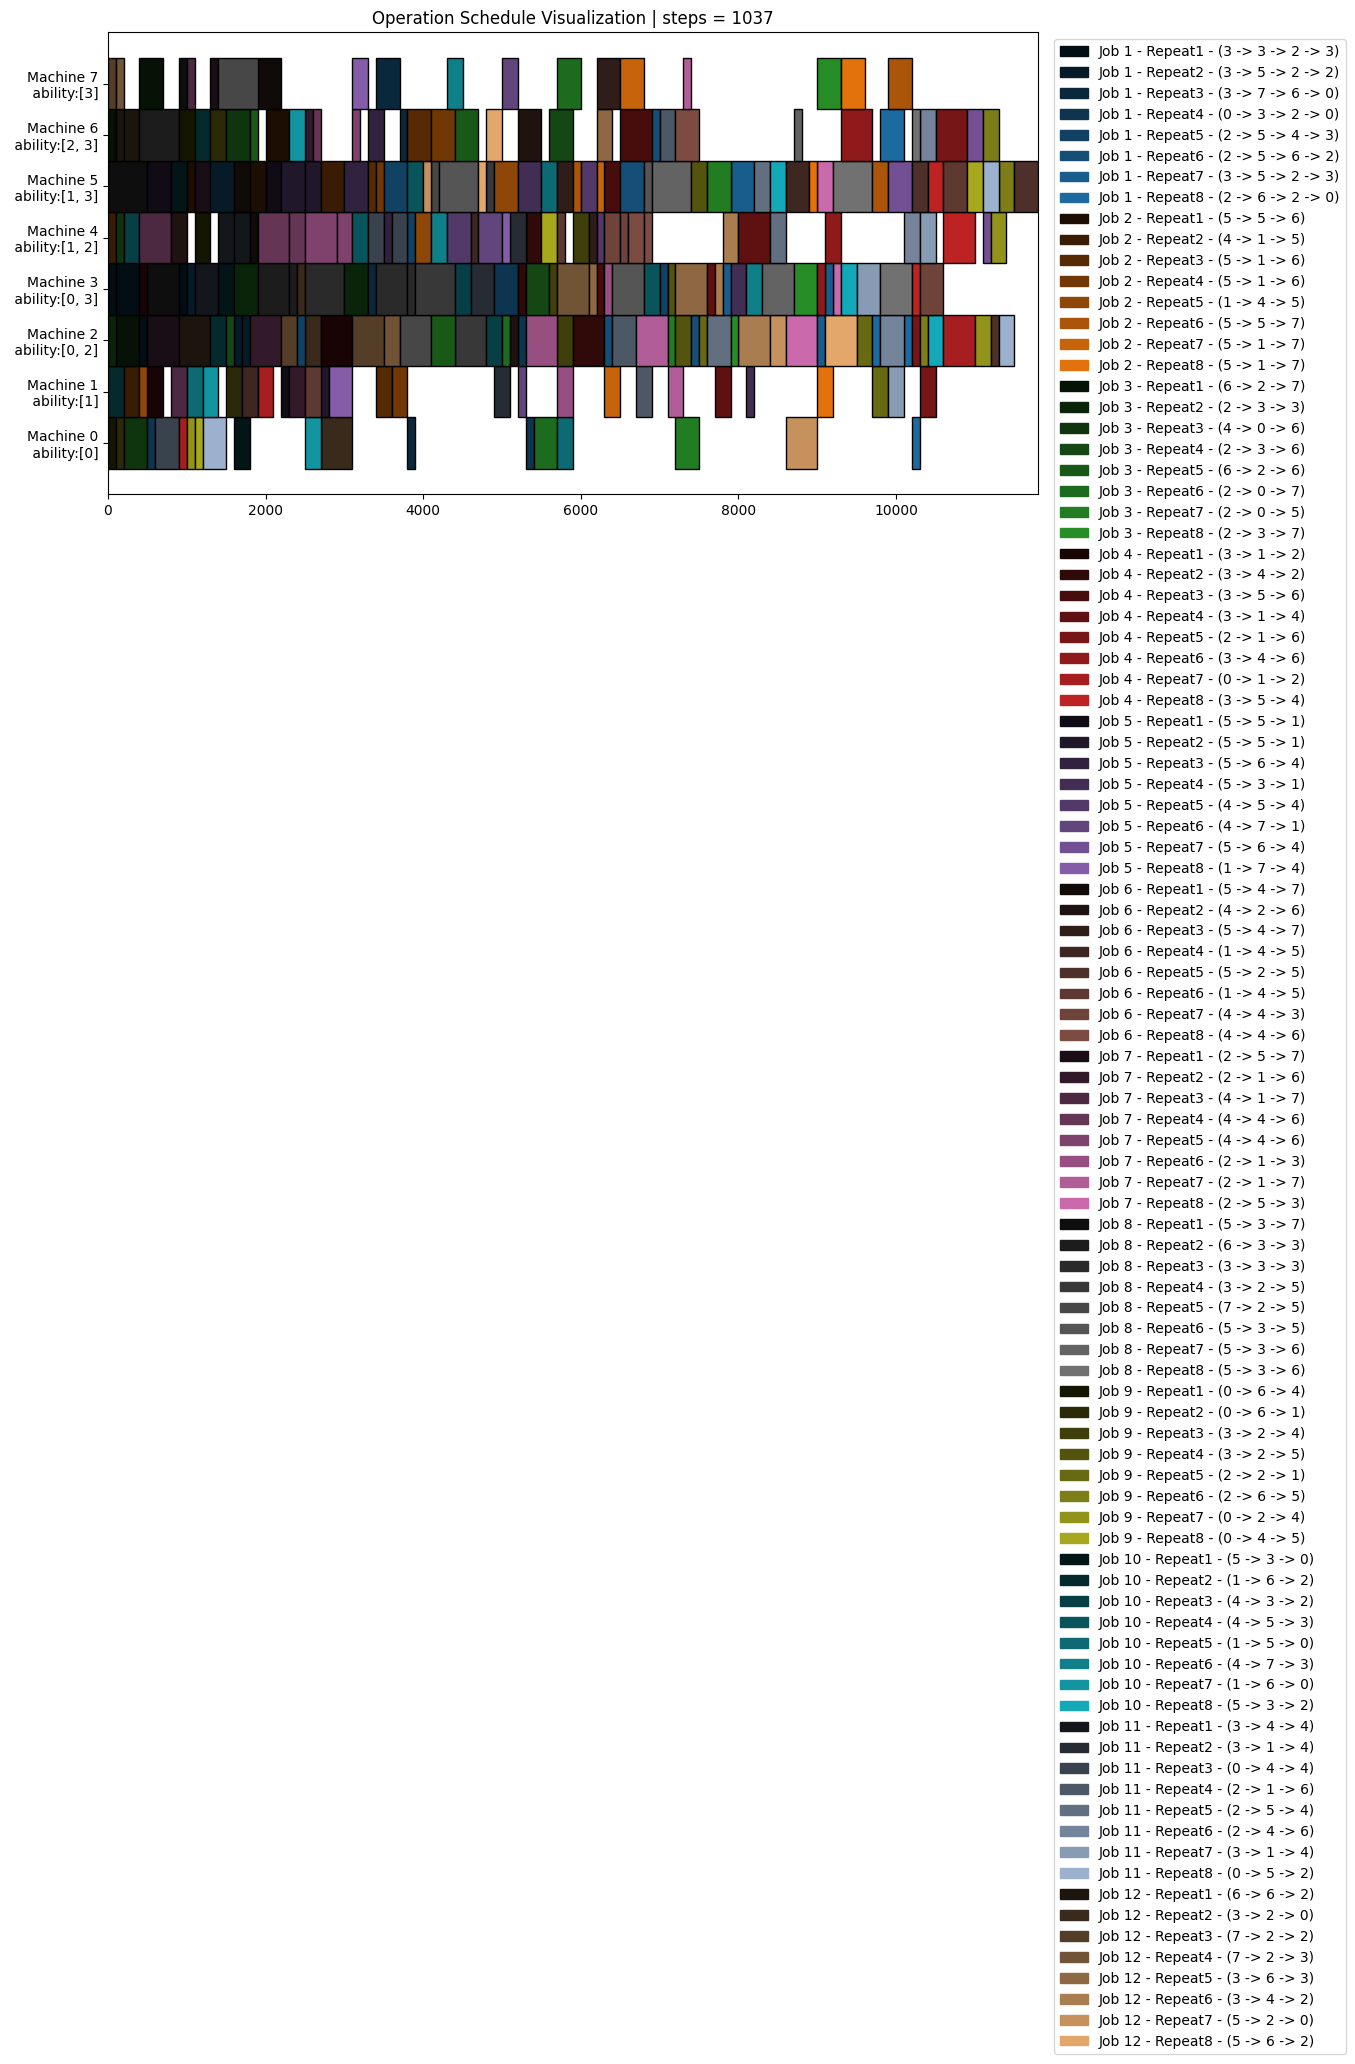

In [21]:
obs, info = env.reset()
while True:
    action_masks = env.action_masks()
    action, _states = model.predict(obs, action_masks=action_masks, deterministic = True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    #env.render()
    info["reward"] = reward
    info["env"] = env
    info["profit_ratio"] = env.profit_per_time
    
    if done:    
        print_result(info, detail_mode = False)
        env.render()
        break

print()
print()
print()
print("---------------------------Random Simmulation---------------------------")
random_tardiness_simulation(info["current_repeats"])

In [26]:
# job_paths와 machine_paths를 포함하는 목록
job_paths = ["instances/Jobs/v0-12-repeat.json"]
machine_paths = ["instances/Machines/v0-8.json"]

def make_env(job_path, machine_path, test_mode, job_repeats_params):
    def _init():
        env = SchedulingEnv(job_config_path=job_path, machine_config_path=machine_path, job_repeats_params = job_repeats_params, weight_final_time = 50, weight_job_deadline = 50, weight_op_rate = 0, test_mode = test_mode)
        return env
    return _init

envs = [make_env(job_paths[0], machine_paths[0], True, [(3, 1)]*12), make_env(job_paths[0], machine_paths[0], False, [(3, 1)]*12)]

vec_env = SubprocVecEnv(envs)

KeyboardInterrupt: 